## Import Libraries

In [3]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

## Load the Data

In [4]:
df = pd.read_csv("Data/data_saudi_used_cars.csv")

In [5]:
df.shape

(5624, 11)

In [6]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [8]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [9]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [10]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [11]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [51]:
for i in categorical_features:
    print (df[i].value_counts())

Type
Accent          145
Camry           141
Land Cruiser    133
Hilux           111
Sonata          108
               ... 
Mohave            2
Van               2
Symbol            2
Delta             1
CS95              1
Name: count, Length: 153, dtype: int64
Region
Riyadh            1441
Dammam             675
Jeddah             461
Al-Medina          106
Qassim              95
Al-Ahsa             95
Aseer               75
Makkah              71
Tabouk              43
Khobar              42
Taef                42
Jubail              29
Jazan               28
Abha                27
Hail                21
Al-Baha             15
Najran              12
Al-Jouf             12
Hafar Al-Batin      11
Yanbu               10
Al-Namas             9
Arar                 5
Wadi Dawasir         4
Sakaka               4
Besha                3
Qurayyat             3
Name: count, dtype: int64
Make
Toyota        827
Hyundai       475
Ford          333
Chevrolet     273
Nissan        226
Kia       

In [14]:
df = df[df['Year']>=2000]

In [52]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [21]:
df.shape

(5125, 11)

In [53]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [54]:
df.shape

(3337, 11)

In [27]:
#df[df['Type']=='Other']

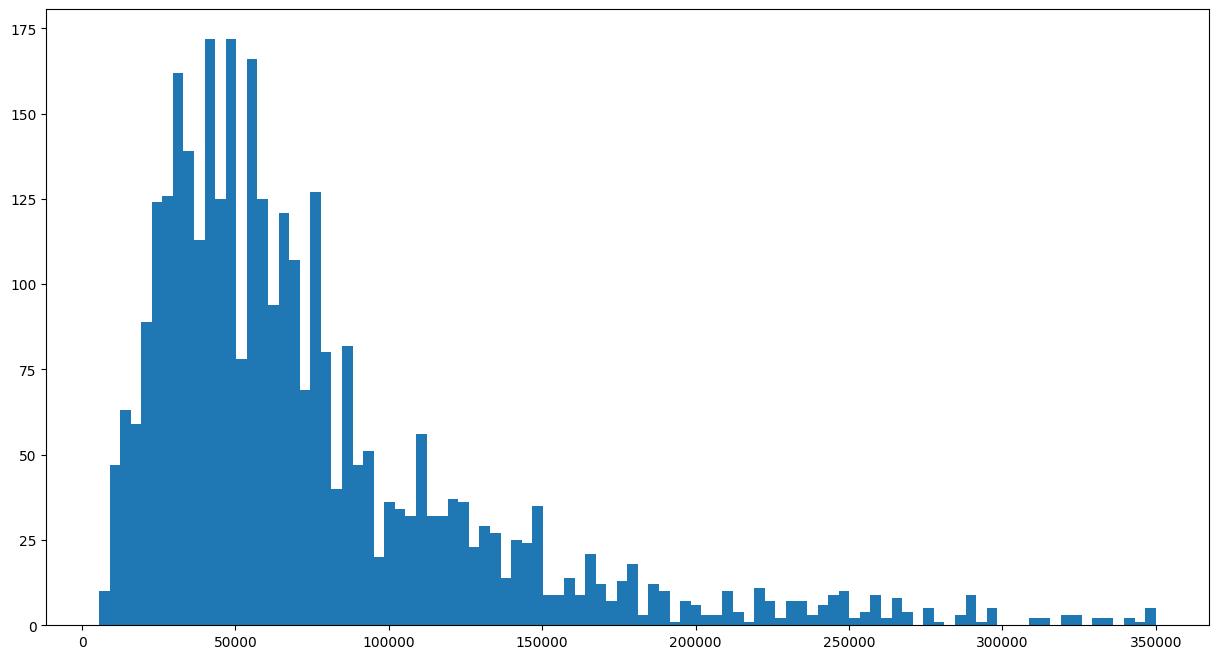

In [36]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=350000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [37]:
df = df[(df['Price']<=350000) & (df['Price']>=5000)]

In [38]:
df.shape

(3393, 11)

In [47]:
#df[df['Mileage']<1000]

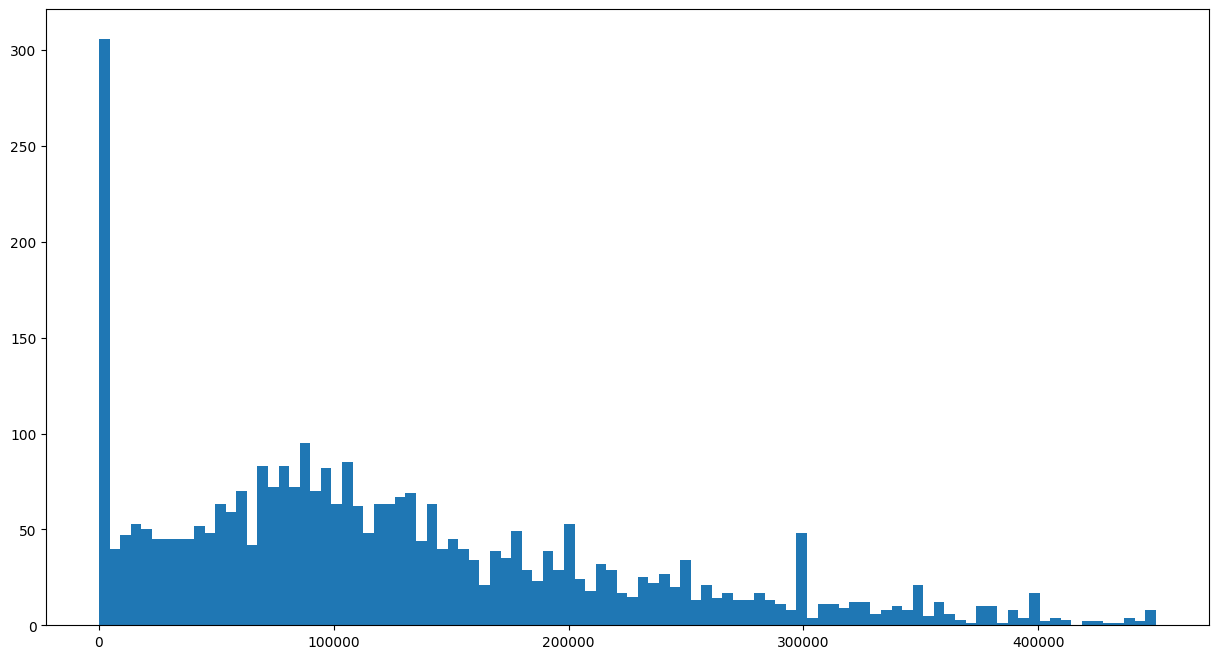

In [49]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);
#plt.hist(df['Mileage'], bins=100);

In [50]:
df = df[df['Mileage']<=450000]
df.shape

(3339, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [55]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000


In [56]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [57]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [58]:
df.shape

(3337, 226)

In [59]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_500,Type_6,Type_A,...,Make_Volkswagen,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
2,2015,5.0,140000,False,260000,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False


#### 3. Feature selection

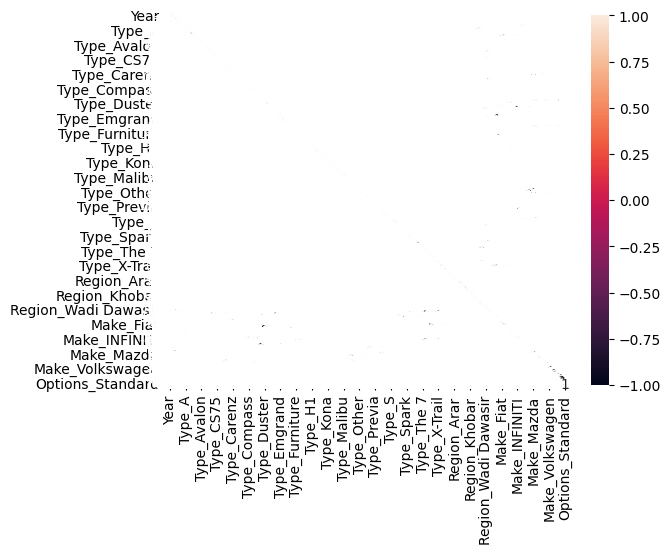

In [60]:
sns.heatmap(df.corr(), annot=True);

In [61]:
correlation = df.corr()
print(correlation['Price'].sort_values(ascending=False))

Price               1.000000
Year                0.387089
Options_Full        0.340320
Engine_Size         0.327487
Make_Mercedes       0.302650
                      ...   
Origin_Saudi       -0.192466
Make_Hyundai       -0.213632
Options_Standard   -0.282673
Mileage            -0.304788
Negotiable               NaN
Name: Price, Length: 226, dtype: float64


In [63]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['Price']) > threshold]['Price'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Price', 'Type_Land Cruiser',
       'Type_Range Rover', 'Make_Hyundai', 'Make_Land Rover', 'Make_Lexus',
       'Make_Mercedes', 'Origin_Gulf Arabic', 'Options_Full',
       'Options_Standard'],
      dtype='object')

In [102]:
selected_features = ['Year', 'Engine_Size', 'Mileage',
                     'Price', 
                     'Make_Hyundai', 'Make_Land Rover', 'Make_Lexus',
                     'Make_Mercedes', 'Origin_Gulf Arabic', 'Options_Full',
                     'Options_Standard']

In [103]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,Price,Make_Hyundai,Make_Land Rover,Make_Lexus,Make_Mercedes,Origin_Gulf Arabic,Options_Full,Options_Standard
1,2014,8.0,80000,120000,False,False,False,False,False,True,False
2,2015,5.0,140000,260000,False,True,False,False,True,True,False
3,2015,2.4,220000,42000,False,False,False,False,False,False,False
5,2019,2.0,25000,58000,False,False,False,False,False,False,False
7,2016,2.4,155,48000,True,False,False,False,False,True,False


#### 4. Prepare train and test data

In [107]:
# Prepare data
X = df.drop(['Price'], axis=1)
y = df['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Buliding the Model

In [80]:
model = LinearRegression()

## Train the Model

In [108]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

## Test the Model

In [109]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [110]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Year,29215.413850
Engine_Size,22591.408501
Mileage,-5876.505854
Make_Hyundai,-5456.385363
Make_Land Rover,9688.380206
Make_Lexus,10194.383198
Make_Mercedes,16941.878392
Origin_Gulf Arabic,4304.132162
Options_Full,8124.898465
Options_Standard,-3847.429332


In [111]:
print(model.intercept_) 

75859.4102660167


## Evaluating the Model 

In [112]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1150974119.3585365


#### Predictions vs. Real Values

In [113]:
predictions = model.predict(X_test_scaled)
#predictions

In [114]:
Real_Values = np.array(y_test)
#Real_Values

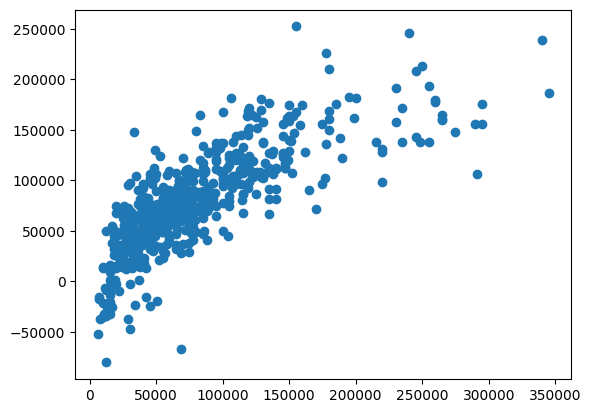

In [115]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

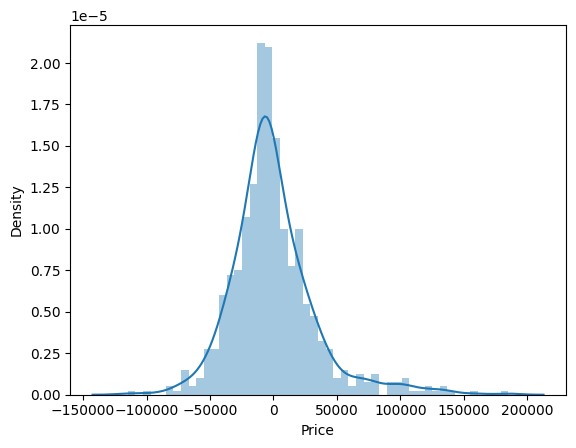

In [116]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution